# Collect Tweets into MongoDB

## Install Python libraries

You may need to restart your Jupyter Notebook instance after installed those libraries.

In [1]:
!pip install pymongo

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 500.9/500.9 KB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.1/269.1 KB 37.5 MB/s eta 0:00:00
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install pymongo[srv]

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [3]:
!pip install dnspython

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [4]:
!pip install tweepy

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 KB 2.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.7/151.7 KB 27.2 MB/s eta 0:00:00
  Using cached requests-2.28.1-py3-none-any.whl (62 kB)
  Attempting uninstall: requests
    Found existing installation: requests 2.26.0
    Uninstalling requests-2.26.0:
      Successfully uninstalled requests-2.26.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
anaconda-project 0.10.2 requires ruamel-yaml, which is not installed.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [5]:
!pip install twitter

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 KB 1.6 MB/s eta 0:00:00
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


## Import Python libraries

In [6]:
import pymongo
from pymongo import MongoClient
import json
import tweepy
import twitter
from pprint import pprint
import configparser
import pandas as pd

##  Load the Authorization Info

Save database connection info and API Keys in a config.ini file and use the configparse to load the authorization info. 

In [7]:
config = configparser.ConfigParser()
config.read('config.ini')

CONSUMER_KEY      = config['mytwitter']['api_key']
CONSUMER_SECRET   = config['mytwitter']['api_secrete']
OAUTH_TOKEN       = config['mytwitter']['access_token']
OATH_TOKEN_SECRET = config['mytwitter']['access_secrete']

mongod_connect = config['mymongo']['connection']

## Connect to the MongoDB Cluster

In [8]:
client = MongoClient(mongod_connect)
db = client.demo # use or create a database named demo
tweet_collection = db.lab11 #use or create a collection named tweet_collection
tweet_collection.create_index([("id", pymongo.ASCENDING)],unique = True) # make sure the collected tweets are unique

'id_1'

## Use the Streaming API to Collect Tweets

Authorize the Stream API 

In [9]:
stream_auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
stream_auth.set_access_token(OAUTH_TOKEN, OATH_TOKEN_SECRET)

strem_api = tweepy.API(stream_auth)

Define the query for the Stream API

In [5]:
track = ['election'] # define the keywords, tweets contain election

locations = [-78.9326449,38.4150904,-78.8816972,38.4450731] #defin the location, in Harrisonburg, VA

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> OR </span> are located in Harrisonburg, VA

In [ ]:
class MyStreamListener(tweepy.StreamListener):
    def on_status(self, status):
        print (status.id_str)
        try:
            tweet_collection.insert_one(status._json)
        except:
            pass
  
    def on_error(self, status_code):
        if status_code == 420:
            #returning False in on_data disconnects the stream
            return False
myStreamListener = MyStreamListener()
myStream = tweepy.Stream(auth = strem_api.auth, listener=myStreamListener)
myStream.filter(track=track)#  (locations = locations)   #Use either track or locations

## Use the REST API to Collect Tweets

Authorize the REST API 

In [10]:
rest_auth = twitter.oauth.OAuth(OAUTH_TOKEN,OATH_TOKEN_SECRET,CONSUMER_KEY,CONSUMER_SECRET)
rest_api = twitter.Twitter(auth=rest_auth)

Define the query for the REST API

In [12]:
count = 100 #number of returned tweets, default and max is 100
geocode = "37.5247764,-77.5633011,150mi"  # defin the location, in Harrisonburg, VA
q = "covid19"                               #define the keywords, tweets contain election

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> AND </span> are located in Harrisonburg, VA

In [13]:
search_results = rest_api.search.tweets( count=count,q=q, geocode=geocode) #you can use both q and geocode
statuses = search_results["statuses"]
since_id_new = statuses[-1]['id']
for statuse in statuses:
    try:
        tweet_collection.insert_one(statuse)
        pprint(statuse['created_at'])# print the date of the collected tweets
    except:
        pass

'Thu Nov 17 20:45:11 +0000 2022'
'Thu Nov 17 20:45:00 +0000 2022'
'Thu Nov 17 20:24:19 +0000 2022'
'Thu Nov 17 20:19:38 +0000 2022'
'Thu Nov 17 20:15:22 +0000 2022'
'Thu Nov 17 20:05:10 +0000 2022'
'Thu Nov 17 20:00:05 +0000 2022'
'Thu Nov 17 19:50:17 +0000 2022'
'Thu Nov 17 19:49:44 +0000 2022'
'Thu Nov 17 19:48:27 +0000 2022'
'Thu Nov 17 19:48:16 +0000 2022'
'Thu Nov 17 19:44:59 +0000 2022'
'Thu Nov 17 19:42:25 +0000 2022'
'Thu Nov 17 19:33:33 +0000 2022'
'Thu Nov 17 19:28:22 +0000 2022'
'Thu Nov 17 19:24:21 +0000 2022'
'Thu Nov 17 19:14:08 +0000 2022'
'Thu Nov 17 19:12:48 +0000 2022'
'Thu Nov 17 19:05:10 +0000 2022'
'Thu Nov 17 19:01:13 +0000 2022'
'Thu Nov 17 19:01:11 +0000 2022'
'Thu Nov 17 19:00:01 +0000 2022'
'Thu Nov 17 18:57:21 +0000 2022'
'Thu Nov 17 18:45:58 +0000 2022'
'Thu Nov 17 18:43:28 +0000 2022'
'Thu Nov 17 18:37:43 +0000 2022'
'Thu Nov 17 18:35:08 +0000 2022'
'Thu Nov 17 18:34:00 +0000 2022'
'Thu Nov 17 18:31:11 +0000 2022'
'Thu Nov 17 18:30:01 +0000 2022'
'Thu Nov 1

Continue fetching early tweets with the same query. 
<p><span style="color:red;font-weight:bold">YOU WILL REACH YOUR RATE LIMIT VERY FAST</span></p>

In [16]:
since_id_old = 0
while(since_id_new != since_id_old):
    since_id_old = since_id_new
    search_results = rest_api.search.tweets( count=count,q=q,
                        geocode=geocode, max_id= since_id_new)
    statuses = search_results["statuses"]
    since_id_new = statuses[-1]['id']
    for statuse in statuses:
        try:
            tweet_collection.insert_one(statuse)
            pprint(statuse['created_at']) # print the date of the collected tweets
        except:
            pass

'Thu Nov 10 15:37:53 +0000 2022'
'Thu Nov 10 15:26:07 +0000 2022'
'Thu Nov 10 15:24:44 +0000 2022'
'Thu Nov 10 15:15:07 +0000 2022'
'Thu Nov 10 15:12:27 +0000 2022'
'Thu Nov 10 15:07:35 +0000 2022'
'Thu Nov 10 15:04:09 +0000 2022'
'Thu Nov 10 15:02:28 +0000 2022'
'Thu Nov 10 14:51:53 +0000 2022'
'Thu Nov 10 14:35:01 +0000 2022'
'Thu Nov 10 14:29:33 +0000 2022'
'Thu Nov 10 14:26:29 +0000 2022'
'Thu Nov 10 14:20:27 +0000 2022'
'Thu Nov 10 14:05:04 +0000 2022'
'Thu Nov 10 14:00:01 +0000 2022'
'Thu Nov 10 14:00:00 +0000 2022'
'Thu Nov 10 13:46:14 +0000 2022'
'Thu Nov 10 13:30:00 +0000 2022'
'Thu Nov 10 13:23:39 +0000 2022'
'Thu Nov 10 13:17:24 +0000 2022'
'Thu Nov 10 13:14:12 +0000 2022'
'Thu Nov 10 13:02:52 +0000 2022'
'Thu Nov 10 13:02:50 +0000 2022'
'Thu Nov 10 13:00:04 +0000 2022'
'Thu Nov 10 12:24:54 +0000 2022'
'Thu Nov 10 12:12:11 +0000 2022'
'Thu Nov 10 12:00:58 +0000 2022'
'Thu Nov 10 11:13:11 +0000 2022'
'Thu Nov 10 10:55:47 +0000 2022'
'Thu Nov 10 10:30:06 +0000 2022'
'Thu Nov 1

## View the Collected Tweets

Print the number of tweets and unique twitter users

In [17]:
print(tweet_collection.estimated_document_count())# number of tweets collected

user_cursor = tweet_collection.distinct("user.id")
print (len(user_cursor)) # number of unique Twitter users 

940
501


Create a text index and print the Tweets containing specific keywords. 

In [18]:
tweet_collection.create_index([("text", pymongo.TEXT)], name='text_index', default_language='english') # create a text index


'text_index'

Create a cursor to query tweets with the created index

In [20]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "covid19"}}) # return tweets contain vote

Use pprint to display tweets

In [21]:

for document in tweet_cursor[0:10]: # display the first 10 tweets from the query
    try:
        print ('----')
#         pprint (document) # use pprint to print the entire tweet document
   
        print ('name:', document["user"]["name"]) # user name
        print ('text:', document["text"])         # tweets
    except:
        print ("***error in encoding")
        pass

----
name: University of California Health
text: 3/7  9 #COVID19 @UofCAHealth inpatients are on a ventilator. 0 COVID19 inpatients are on extracorporeal membrane ox… https://t.co/Y4UhTYN0D5
----
name: Absolut.LIBRA
text: Whoopi has #COVID19 #TheView
----
name: George Robert Martin III aka: "Nemesis Rising TV"
text: #COVID19 = POPULATION CONTROL AND YOU ALL FELL FOR IT.
----
name: Paradise Lost CA
text: #covid19 https://t.co/6zxWRro0qt
----
name: Cheryl Cunha
text: @mikepompeo And they don't need mandatory Covid19 vaccines.
----
name: CryDiego
text: @SethDillon @MattWalshBlog Just think of the trillions for COVID19
----
name: ████ Tech Savvy ████
text: #IYKYK #COVID19 https://t.co/TJ3eehZsBu
----
name: Oscar Cingolani, M.D.
text: #COVID19 #covidusa https://t.co/rvFeovbHqN
----
name: 757 Progressive™️🆘🦠🇺🇸🌏🔥
text: 🧵 on the #PermanentPandemic of #COVID19 https://t.co/5JN030xSvM
----
name: Erik Glasser
text: #Simpsons #COVID19 #planned https://t.co/Me6LRnXI3w


In [22]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "vote"}}) # return tweets contain vote

Use pandas to display tweets

In [23]:
tweet_df = pd.DataFrame(list(tweet_cursor ))
tweet_df[:10] #display the first 10 tweets

,_id,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,...,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,quoted_status_id,quoted_status_id_str,quoted_status
0,6376a0fd75cfb81f05556e68,Wed Nov 16 14:48:04 +0000 2022,1592892264019369985,1592892264019369985,Only 1⃣ week to cast your vote! \nThe @infobea...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://sproutsocial.com"" rel=""nofoll...",None,...,False,2,3,False,False,False,en,NaN,NaN,NaN
1,6376a16175cfb81f05557136,Wed Nov 09 11:20:33 +0000 2022,1590303321910575107,1590303321910575107,Look what the fascistic left did to people dur...,True,"{'hashtags': [{'text': 'covid19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",None,...,True,0,0,False,False,False,en,1.589998e+18,1589997631774011396,{'created_at': 'Tue Nov 08 15:05:50 +0000 2022...
2,6376a0fd75cfb81f05556e8e,Wed Nov 16 01:35:36 +0000 2022,1592692830866055168,1592692830866055168,".@SenateDems, why would you vote to end the #C...",True,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",None,...,True,2,5,False,False,False,en,1.592687e+18,1592686727281401856,{'created_at': 'Wed Nov 16 01:11:21 +0000 2022...
3,6376a0fd75cfb81f05556e63,Wed Nov 16 15:05:46 +0000 2022,1592896714654220292,1592896714654220292,Hey @MarkWarner as your constituent who's been...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",None,...,True,2,4,False,False,False,en,1.592804e+18,1592804135401033728,{'created_at': 'Wed Nov 16 08:57:53 +0000 2022...


<AxesSubplot:>

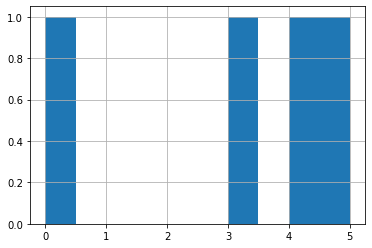

In [24]:
tweet_df["favorite_count"].hist() # create a histogram show the favorite count